# Install and import packages

In [1]:
try:
    import google.colab
    IN_COLAB = True
    !pip install stable-baselines3[extra] ale-py==0.7.4
except:
    IN_COLAB = False

import platform
ON_WINDOWS = True if platform.system() == 'Windows' else False

import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline
import math
import copy
import cv2
from line_profiler import LineProfiler

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack

if IN_COLAB or ON_WINDOWS: device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
else:
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
    # device = torch.device('cpu')


def query_environment(name):
    env = gym.make(name)
    spec = gym.spec(name)
    print(f'Action Space: {env.action_space}')
    print(f'Observation Space: {env.observation_space}')
    print(f'Max Episode Steps: {spec.max_episode_steps}')
    print(f'Nondeterministic: {spec.nondeterministic}')
    print(f'Reward Range: {env.reward_range}')
    print(f'Reward Threshold: {spec.reward_threshold}')
    return env, spec

device

device(type='cuda', index=0)

In [2]:
def explained_variance(y_pred: np.ndarray, y_true: np.ndarray) -> np.ndarray:
    """
    Computes fraction of variance that ypred explains about y.
    Returns 1 - Var[y-ypred] / Var[y]
    interpretation:
        ev=0  =>  might as well have predicted zero
        ev=1  =>  perfect prediction
        ev<0  =>  worse than just predicting zero
    :param y_pred: the prediction
    :param y_true: the expected value
    :return: explained variance of ypred and y
    """
    assert y_true.ndim == 1 and y_pred.ndim == 1
    var_y = np.var(y_true)
    return np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y

In [3]:
def preprocess_frame(frame, size=(84, 84)):
    '''
    1. Convert RGB to YUV 
    2. Extract Y channel (luminance)
    3. Resize frame
    '''
    img_yuv = cv2.cvtColor(frame, cv2.COLOR_BGR2YUV)
    y, _, _ = cv2.split(img_yuv)
    new_frame = cv2.resize(y, size)
    return new_frame

# Proximal Policy Optimisation (PPO)

In [4]:
class PPOAgent:
    def agent_init(self, agent_init_info):
        # Store the parameters provided in agent_init_info.
        self.num_actions = agent_init_info['num_actions']               # num of actions (scalar)
        self.obs_size = agent_init_info['obs_size']                     # dimension of observation (scalar)
        self.lr = agent_init_info['learning_rate']                      # learning rate for total loss from actor, critic, entropy
        self.discount = agent_init_info['discount']                     # discount factor i.e. gamma
        self.gae_lambda = agent_init_info['gae_lambda']                 # gae lambda factor
        self.vf_loss_beta = agent_init_info['value_function_loss_beta'] # coefficient for critic loss
        self.entropy_loss_beta = agent_init_info['entropy_loss_beta']   # coefficient for entropy loss
        self.batch_size = agent_init_info['batch_size']                 # num of steps to include in each minibatch
        self.train_steps = agent_init_info['train_steps']               # num of steps per training cycle
        self.n_epochs = agent_init_info['n_epochs']                     # num of epochs to train per train_steps
        self.clip_param = agent_init_info['clip_param']                 # clip log_prob ratio to [1-clip_param, 1+clip_param]
        self.discrete = agent_init_info['discrete']                     # whether actions are discrete (categorical) or continuous (Gaussian)
        self.total_steps = agent_init_info['total_steps']               # total steps to train before stopping
        self.scheduler_steps = agent_init_info['scheduler_steps']       # num steps before stepping scheduler (should be multiple of train_steps)
        self.max_grad_norm = 0.5
        self.device = agent_init_info['device']
        self.rng = np.random.default_rng()

        self.debug_list = []

        try:
            dir = agent_init_info['tensorboard_log_dir']
            self.writer = SummaryWriter() if dir == 'default' else SummaryWriter(dir)
            self.tensorboard = True
        except: self.tensorboard = False

        try: self.kl_threshold = agent_init_info['kl_threshold']
        except: self.kl_threshold = None # checked on the mean kl div after every train cycle i.e. every n_epochs

        try:
            log_std_init = agent_init_info['log_std_init']
            self.log_std_annealing_rate = agent_init_info['log_std_annealing_rate']
            self.log_std_lr = agent_init_info['log_std_lr']
        except:
            log_std_init = 0.
            self.log_std_annealing_rate = -0.001 # added to self.log_std after every train cycle i.e. every n_epochs
            self.log_std_lr = 0.0001

        if not self.discrete:
            self.log_std = nn.Parameter(torch.zeros(self.num_actions, dtype=torch.float32) + log_std_init)
            self.log_std_optim = torch.optim.Adam([self.log_std], lr=self.log_std_lr)

        try: self.actor = agent_init_info['actor_model']
        except:
            self.actor = nn.Sequential(
                nn.Linear(self.obs_size, 64),
                nn.Tanh(),
                nn.Linear(64, 64),
                nn.Tanh(),
                nn.Linear(64, self.num_actions),
            )
        self.actor.to(self.device)

        try: self.critic = agent_init_info['critic_model']
        except: self.critic = nn.Sequential(
                nn.Linear(self.obs_size, 64),
                nn.Tanh(),
                nn.Linear(64, 64),
                nn.Tanh(),
                nn.Linear(64, 1),
            )
        self.critic.to(self.device)
        self.optimizer = torch.optim.Adam(set(list(self.actor.parameters()) + list(self.critic.parameters())), lr=self.lr) # set important to prevent duplicate params in shared network
        self.scheduler = torch.optim.lr_scheduler.LinearLR(self.optimizer, start_factor=1.0, end_factor=0.0, total_iters=self.total_steps / self.scheduler_steps)

        self.training_mode = True   # for train mode actions
        self.steps = 0              # to keep track for training
        self.episode = 1            # for logging of episode lengths and rewards
        self.buffer = []
        self.n_batchs = math.ceil(self.train_steps / self.batch_size)

    def agent_start(self, observation):
        # for tensorboard logging
        self.cum_reward = 0

        obs = torch.tensor(observation, dtype=torch.float32).unsqueeze(0) # only obs, out of all transition elements in buffer, has additional batch dim
        action, log_prob = self.get_action(obs)
        self.update_internal_states(obs, action, log_prob)
        return action.numpy().squeeze()

    def agent_step(self, reward, observation):
        # for tensorboard logging
        self.cum_reward += np.squeeze(reward)

        # gae computation requires last state of agent (not in the buffer)
        self.next_state = torch.tensor(observation, dtype=torch.float32).unsqueeze(0)

        reward = torch.tensor([reward], dtype=torch.float32) if np.shape(reward)==() else torch.tensor(reward, dtype=torch.float32) # some env gives reward as a (1,) array
        # must be before new action/obs replaces self.prev_action/self.prev_state which are not passed into function but are moved into buffer
        if self.training_mode: self.train_mode_actions(reward, True) 

        action, log_prob = self.get_action(self.next_state)
        self.update_internal_states(self.next_state, action, log_prob)
        return action.numpy().squeeze()

    def agent_end(self, reward, observation):
        # for tensorboard logging
        self.cum_reward += np.squeeze(reward)

        # gae computation requires last state of agent and whether it is terminal (not in the buffer)
        self.next_state = torch.tensor(observation, dtype=torch.float32).unsqueeze(0)

        reward = torch.tensor([reward], dtype=torch.float32) if np.shape(reward)==() else torch.tensor(reward, dtype=torch.float32) # some env gives reward as a (1,) array
        if self.training_mode: self.train_mode_actions(reward, False)
        if self.tensorboard: self.episode_log()

    def update_internal_states(self, observation, action, log_prob):
        self.prev_state = observation
        self.prev_action = action
        self.log_prob = log_prob
        with torch.no_grad(): self.critic_value = self.critic(observation.to(self.device)).cpu().squeeze(0) # remove batch dim for single instance

    def get_action(self, observation, return_dist=False):
        observation = observation.to(self.device)
        if self.discrete:
            logits = self.actor(observation)
            action_dist = torch.distributions.Categorical(logits=logits)
        else:
            batch_mean = self.actor(observation)
            batch_cov = torch.diag((2*self.log_std).exp()).repeat(batch_mean.shape[0], 1, 1).to(self.device)
            action_dist = torch.distributions.MultivariateNormal(batch_mean, covariance_matrix=batch_cov)

        if return_dist:
            return action_dist
        else:
            action = action_dist.sample().detach()
            log_prob = action_dist.log_prob(action).detach()
            return action.cpu(), log_prob.cpu()

    #NOTE: consider correct sequence of train and adding to buffer
    def train_mode_actions(self, reward, next_state_not_terminal):
        self.steps += 1 # completion of a full transition
        next_state_not_terminal = torch.tensor([next_state_not_terminal], dtype=torch.bool)
        transition = (self.prev_state, self.critic_value, self.prev_action, self.log_prob, reward, next_state_not_terminal)
        self.buffer.append(transition)
        if (self.steps % self.train_steps == 0): self.train()
        if (self.steps % self.scheduler_steps == 0): self.scheduler.step()

    def train(self):
        # process transitions from each step = tuple to vertical stack of types of transition and calculate gae/returns
        unpacked_tuples = zip(*self.buffer)
        current_states, current_critic_values, actions, old_log_probs, rewards, next_state_not_terminals = (torch.cat(tuple) for tuple in unpacked_tuples)
        advantages, returns = self.compute_gae_and_returns(current_critic_values, rewards, next_state_not_terminals)
        self.set_diagnostics()

        # for unrolling of training if kl_div breaches
        # actor_state_dict = self.actor.state_dict()
        # critic_state_dict = self.critic.state_dict()

        for epoch in range(self.n_epochs):
            indices = np.arange(self.train_steps)
            self.rng.shuffle(indices) # randomised indices to shuffle transitions and ensure each data point is used (if train_steps % batch_size = 0)
            self.kl_breach = False

            for i in range(self.n_batchs):
                if self.kl_breach: break
                start = i * self.batch_size
                end = start + self.batch_size
                batch_indices = indices[start:end]
                batch = (tensors[batch_indices] for tensors in (current_states, actions, old_log_probs, advantages, returns))
                self.train_batch(*batch)
            if self.kl_breach: break

        self.buffer = [] # clear buffer after full batch has been used for training
        if not self.discrete:
            with torch.no_grad(): self.log_std += self.log_std_annealing_rate # apply log_std annealing

        kl_div = self.diagnostics() # tensorboard log

        # if kl_div > self.kl_threshold: # unroll updates if kl_div breaches threshold
        #     self.actor.load_state_dict(actor_state_dict)
        #     self.critic.load_state_dict(critic_state_dict)

    def train_batch(self, current_states, actions, old_log_probs, advantages, returns):
        current_states, actions, old_log_probs, advantages, returns = \
            self.to_device([current_states, actions, old_log_probs, advantages, returns])

        action_dist = self.get_action(current_states, return_dist=True)
        #NOTE certain distributions not supported on mps yet
        # if self.device == torch.device('mps'): new_log_probs = action_dist.log_prob(actions.cpu()).to(self.device)
        # else: new_log_probs = action_dist.log_prob(actions)
        new_log_probs = action_dist.log_prob(actions)

        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        log_prob_diff = new_log_probs - old_log_probs
        ratios = log_prob_diff.exp()
        surr1 = ratios * advantages
        surr2 = torch.clamp(ratios, 1. - self.clip_param, 1. + self.clip_param) * advantages
        actor_loss  = -torch.min(surr1, surr2).mean()

        with torch.no_grad(): approx_kl_div = (ratios - 1 - log_prob_diff).detach().mean().cpu().numpy() # from schulman blog for low variance estimator
        self.kl_divs.append(approx_kl_div)

        if self.kl_threshold is not None and approx_kl_div > 1.5 * self.kl_threshold: self.kl_breach = True

        critic_values = self.critic(current_states).squeeze()
        # assert critic_values.shape == returns.shape, 'critic_values shape: ' + str(critic_values.shape) + '\nreturns shape: ' + str(returns.shape)
        critic_loss = F.mse_loss(returns, critic_values)

        entropy = action_dist.entropy().mean() if self.entropy_loss_beta > 0 else 0.
        # assert self.vf_loss_beta > 0, 'Value function loss beta is not positive'

        loss = actor_loss + self.vf_loss_beta * critic_loss - self.entropy_loss_beta * entropy

        if self.tensorboard:
            d_ratios = ratios.detach().cpu().numpy()
            self.clip_ind.append(((d_ratios < 1 - self.clip_param) + (d_ratios > 1 + self.clip_param)))
            self.actor_losses.append(actor_loss.detach().cpu().numpy())
            self.critic_losses.append(critic_loss.detach().cpu().numpy())
            self.entropies.append(entropy.detach().cpu().numpy())
            self.losses.append(loss.detach().cpu().numpy())

        self.optimizer.zero_grad()
        if not self.discrete: self.log_std_optim.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(set(list(self.actor.parameters()) + list(self.critic.parameters())), self.max_grad_norm)
        self.optimizer.step()
        if not self.discrete: self.log_std_optim.step()

    def compute_gae_and_returns(self, critic_values, rewards, next_state_not_terminals):
        with torch.no_grad():
            gae = 0
            advantages = torch.zeros_like(rewards)
            for t in reversed(range(self.train_steps)):
                # for last state in buffer, must calculate next state critic value based on stored final obs
                if t == self.train_steps - 1: next_state_value = self.critic(self.next_state.to(self.device)).cpu().squeeze(0) # remove batch dim for single instance
                else: next_state_value = critic_values[t+1]

                # gae starts with last transition in buffer so if it is the last transition, it will just be final reward - value(final state)
                # not_terminal will break the gae continuing product when transitioning to different episode
                delta = rewards[t] + self.discount * next_state_value * next_state_not_terminals[t] - critic_values[t]
                gae = delta + self.discount * self.gae_lambda * next_state_not_terminals[t] * gae
                advantages[t] = gae
            # assert advantages.shape == critic_values.shape, 'advantage shape: ' + str(advantages.shape) + '\ncritic_values shape: ' + str(critic_values.shape)
            returns = advantages + critic_values
            return advantages, returns

    def set_diagnostics(self):
        self.kl_divs = [] # for debugging or early stopping
        self.clip_ind = []
        self.actor_losses = []
        self.critic_losses = []
        self.entropies = []
        self.losses = []

    def diagnostics(self):
        kl_div = np.mean(self.kl_divs)
        if self.tensorboard:
            clip_ind = np.array(self.clip_ind).flatten()
            self.writer.add_scalar('Mean-KL_div:', kl_div, self.steps)
            self.writer.add_scalar('Clip_ratio', clip_ind.sum() / len(clip_ind), self.steps)
            self.writer.add_scalar('Learning_rate',  self.optimizer.param_groups[0]['lr'], self.steps)
            self.writer.add_scalar('Actor_loss', np.mean(self.actor_losses), self.steps)
            self.writer.add_scalar('Critic_loss', np.mean(self.critic_losses), self.steps)
            self.writer.add_scalar('Entropy_loss', np.mean(self.entropies), self.steps)
            self.writer.add_scalar('Total_loss', np.mean(self.losses), self.steps)
        return kl_div

    def episode_log(self):
        if self.episode == 1:
            self.cum_length = self.steps
            episode_length = self.steps
        else:
            episode_length = self.steps - self.cum_length
            self.cum_length = self.steps
        self.writer.add_scalar('Episode_len', episode_length, self.steps)
        self.writer.add_scalar('Cum_reward', self.cum_reward, self.steps)
        self.episode += 1

    def to_device(self, list):
        device_var = []
        for var in list:
            var = var.to(self.device)
            device_var.append(var)
        return device_var

# Pong

In [5]:
# There already exists an environment generator that will make and wrap atari environments correctly.
env = make_atari_env('PongNoFrameskip-v4', n_envs=1, seed=0)
# Stack 4 frames
env = VecFrameStack(env, n_stack=4)

In [6]:
share_feature_extractor = True
obs_dim = len(env.observation_space.sample())
obs_shape = env.observation_space.sample().shape
print('Observation dim:', obs_shape)
n_actions = env.action_space.n
print('num_actions:', n_actions)

class Feature_Extractor(torch.nn.Module):

    def __init__(self):
        super(Feature_Extractor, self).__init__()

        self.net = nn.Sequential(
            nn.Conv2d(obs_shape[-1], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, 512),
            nn.ReLU(),
        )

    def forward(self, x):
        # x = x.permute(0, 3, 1, 2)
        x = self.net(x)
        return x

if share_feature_extractor:
    shared_feature_extractor = Feature_Extractor()
    actor_feature_extractor = critic_feature_extractor = shared_feature_extractor
else:
    actor_feature_extractor = Feature_Extractor()
    critic_feature_extractor = Feature_Extractor()

actor_model = nn.Sequential(
    actor_feature_extractor,
    nn.Linear(512, n_actions)
)

critic_model = nn.Sequential(
    critic_feature_extractor,
    nn.Linear(512, 1)
)

agent_info = {
    'num_actions': n_actions,
    'obs_size': obs_dim,
    'learning_rate': 2.5e-4,
    'discount': 0.99,
    'batch_size': 32, # num of steps
    'train_steps': 128,
    'gae_lambda': 0.95,
    'value_function_loss_beta': 0.5,
    'entropy_loss_beta': 0.01,
    'n_epochs': 4,
    'clip_param': 0.1,
    'discrete': True,
    'actor_model': actor_model,
    'critic_model': critic_model,
    'total_steps': 1e6,
    'scheduler_steps': 1e4,
    'tensorboard_log_dir': './runs/pong/run_3/',
    'device': device
}
nn_agent = PPOAgent()
nn_agent.agent_init(agent_info)

Observation dim: (84, 84, 4)
num_actions: 6


## Training for Pong

In [7]:
# Training
nn_agent.training_mode = True

rewards = []
episode_lens = []
i = 0

while True:
    actions = []
    obs = env.reset()
    obs = obs.transpose((0,-1,1,2)).squeeze(0)
    action = nn_agent.agent_start(obs)
    cum_episode_rewards = 0

    for t in range(10000):
        actions.append(action)
        obs, reward, done, info = env.step([action])
        obs = obs.transpose((0,-1,1,2)).squeeze(0)
        cum_episode_rewards += reward

        if done:
            nn_agent.agent_end(reward, obs)
            print(str(t+1) + '(' + str(int(cum_episode_rewards)) + ')', end=' ')
            print(f'({np.std(actions):.2f})', end=' ')
            episode_lens.append(t+1)
            rewards.append(cum_episode_rewards)
            if (i+1)%20==0: print('\nEnd of episode', i+1)
            i += 1
            break
        else:
            action = nn_agent.agent_step(reward, obs)
    if nn_agent.steps >= agent_info['total_steps']: break

906(-21) (1.30) 1058(-21) (1.41) 819(-21) (1.36) 813(-21) (1.33) 812(-21) (1.38) 842(-21) (1.46) 818(-21) (1.50) 815(-21) (1.66) 819(-21) (1.56) 911(-20) (1.43) 825(-20) (1.57) 827(-20) (1.54) 825(-20) (1.52) 819(-21) (1.48) 831(-20) (1.32) 1151(-19) (1.44) 924(-20) (1.50) 1139(-21) (1.45) 996(-20) (1.54) 931(-21) (1.54) 
End of episode 20
1286(-19) (1.58) 1121(-20) (1.56) 1198(-19) (1.52) 930(-20) (1.46) 1133(-21) (1.39) 1316(-18) (1.36) 978(-20) (1.34) 1000(-21) (1.25) 850(-20) (1.26) 1294(-18) (1.31) 1037(-21) (1.31) 1076(-18) (1.37) 904(-20) (1.42) 1055(-20) (1.36) 1300(-19) (1.32) 950(-20) (1.41) 1028(-18) (1.50) 1040(-20) (1.40) 1214(-19) (1.33) 830(-20) (1.21) 
End of episode 40
1163(-20) (1.06) 1126(-19) (0.98) 1392(-19) (1.05) 1045(-20) (1.05) 1431(-16) (0.98) 1219(-19) (1.16) 1550(-15) (1.18) 1440(-16) (1.19) 1408(-19) (1.18) 1265(-19) (1.14) 1209(-17) (1.24) 1068(-19) (1.30) 1345(-16) (1.31) 1340(-17) (1.21) 1512(-17) (1.27) 1031(-21) (1.30) 757(-21) (1.28) 840(-21) (1.39) 9

In [8]:
torch.save(nn_agent.actor.state_dict(), './actor_state_dict_v3.pt')
torch.save(nn_agent.critic.state_dict(), './critic_state_dict_v3.pt')

In [21]:
env.reset()[0,:10,:10,3]

array([[ 52,  52,  52,  52,  80,  87,  87,  87,  87,  87],
       [ 87,  87,  87,  87,  87,  87,  87,  87,  87,  87],
       [ 87,  87,  87,  87,  87,  87,  87,  87,  87,  87],
       [ 87,  87,  87,  87,  87,  87,  87,  87,  87,  87],
       [ 87,  87,  87,  87,  87,  87,  87,  87,  87,  87],
       [ 87,  87,  87,  87,  87,  87,  87,  87,  87,  87],
       [ 87,  87,  87,  87,  87,  87,  87,  87,  87,  87],
       [ 87,  87,  87,  87,  87,  87,  87,  87,  87,  87],
       [ 87,  87,  87,  87,  87,  87,  87,  87,  87,  87],
       [147, 147, 147, 147, 147, 147, 147, 147, 147, 147]], dtype=uint8)

## Video evaluation

In [36]:
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv

nn_agent.training_mode = False

video_folder = './video'
video_length = 3000
video_env = make_atari_env('PongNoFrameskip-v4', n_envs=1, seed=0)
video_env = VecFrameStack(video_env, n_stack=4)

# Record the video starting at the first step
video_env = VecVideoRecorder(video_env, video_folder,
                       record_video_trigger=lambda x: x == 0, video_length=video_length,
                       name_prefix='PPO-Pong')

obs = video_env.reset()
obs = obs.transpose((0,-1,1,2)).squeeze(0)
action = nn_agent.agent_start(obs)
cum_episode_rewards = 0
for t in range(video_length + 1):
    obs, reward, done, info = video_env.step([action])
    obs = obs.transpose((0,-1,1,2)).squeeze(0)
    cum_episode_rewards += reward

    if done:
        nn_agent.agent_end(reward, obs)
        print(str(t+1) + '(' + str(int(cum_episode_rewards)) + ')', end=' ')
        print(f'({np.std(actions):.2f})', end=' ')
        break
    else:
        action = nn_agent.agent_step(reward, obs)

# Save the video
video_env.close()

1622(20) (1.60) 

: 

## Line profiling using Pong

In [5]:
nn_agent.agent_init(agent_info)
obs = env.reset()
obs = obs.transpose((0,-1,1,2)).squeeze(0)
action = nn_agent.agent_start(obs)      

for t in range(127):
    previous_obs = obs
    obs, reward, done, info = env.step([action])
    obs = obs.transpose((0,-1,1,2)).squeeze(0)
    action = nn_agent.agent_step(reward, obs)

nn_agent.steps -= 1 # trick agent to do one more train_mode action without activating training
obs, reward, done, info = env.step([action])
obs = obs.transpose((0,-1,1,2)).squeeze(0)
action = nn_agent.agent_step(reward, obs)

lp = LineProfiler()
lp_wrapper = lp(nn_agent.train)
lp_wrapper()
lp.print_stats()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (336x84 and 3136x512)

In [ ]:
current_states = torch.randn((32, 4, 84, 84))
actions = torch.ones((32))
old_log_probs = torch.randn((32))
advantages = torch.randn((32))
returns = torch.randn((32))

lp = LineProfiler()
lp_wrapper = lp(nn_agent.train_batch)
lp_wrapper(current_states, actions, old_log_probs, advantages, returns)
lp.print_stats()

Timer unit: 1e-06 s

Total time: 0.047605 s
File: /var/folders/nd/wwb7zyc94wsf4ql14n77712h0000gn/T/ipykernel_28924/2015360730.py
Function: train_batch at line 132

Line #      Hits         Time  Per Hit   % Time  Line Contents
   132                                               def train_batch(self, current_states, actions, old_log_probs, advantages, returns):
   133         1          1.0      1.0      0.0          current_states, actions, old_log_probs, advantages, returns = \
   134         1       3363.0   3363.0      7.1              self.to_device([current_states, actions, old_log_probs, advantages, returns])
   135                                           
   136         1      13695.0  13695.0     28.8          action_dist = self.get_action(current_states, return_dist=True)
   137         1        627.0    627.0      1.3          if self.device == torch.device('mps'): new_log_probs = action_dist.log_prob(actions.cpu()).to(self.device)
   138                                   

In [ ]:
critic_values = torch.randn((128))
rewards = torch.randn((128))
not_terminals = torch.tensor(np.ones((128)), dtype=torch.bool)

lp = LineProfiler()
lp_wrapper = lp(nn_agent.compute_gae_and_returns)
lp_wrapper(critic_values, rewards, not_terminals)
lp.print_stats()

Timer unit: 1e-06 s

Total time: 0.020723 s
File: /var/folders/nd/wwb7zyc94wsf4ql14n77712h0000gn/T/ipykernel_28924/2015360730.py
Function: compute_gae_and_returns at line 160

Line #      Hits         Time  Per Hit   % Time  Line Contents
   160                                               def compute_gae_and_returns(self, critic_values, rewards, not_terminals):
   161         1         13.0     13.0      0.1          with torch.no_grad():
   162         1          0.0      0.0      0.0              gae = 0
   163         1       1918.0   1918.0      9.3              advantages = torch.zeros_like(rewards)
   164       129         88.0      0.7      0.4              for t in reversed(range(self.train_steps)):
   165       128         97.0      0.8      0.5                  if t == self.train_steps - 1: # for last state in buffer, must calculate next state critic value based on stored final obs and terminal state check
   166         1      12872.0  12872.0     62.1                     

# Breakout

In [ ]:
def preprocess_frame(frame, size=(84, 84)):
    '''
    1. Convert RGB to YUV 
    2. Extract Y channel (luminance)
    3. Resize frame
    '''
    img_yuv = cv2.cvtColor(frame, cv2.COLOR_BGR2YUV)
    y, _, _ = cv2.split(img_yuv)
    new_frame = cv2.resize(y, size)
    return new_frame

In [ ]:
env, spec = query_environment('Breakout-v0')

Action Space: Discrete(4)
Observation Space: Box([[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]], [[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255

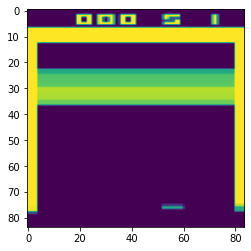

In [ ]:
obs = env.reset()
new_frame = preprocess_frame(obs, (84,84))
plt.imshow(new_frame)

In [ ]:
obs_dim = len(env.observation_space.sample())
n_actions = env.action_space.n
print('num_actions:', n_actions)

class Feature_Extractor(torch.nn.Module):

    def __init__(self):
        super(Feature_Extractor, self).__init__()

        self.activation = nn.ReLU()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(3136, 512)
        self.linear2 = nn.Linear(512, 256)

    def forward(self, x):
        # x = x.permute(0, 3, 1, 2)
        x = self.conv1(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.activation(x)
        x = self.conv3(x)
        x = self.activation(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.activation(x)
        return x

feature_extractor = Feature_Extractor()

actor_model = nn.Sequential(
    feature_extractor, 
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, n_actions)
)

critic_model = nn.Sequential(
    feature_extractor, 
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 1)
)

agent_info = {
    'num_actions': n_actions,
    'obs_size': obs_dim,
    'learning_rate': 0.0003,
    'discount': 0.99,
    'batch_size': 32, # num of steps
    'train_steps': 128,
    'gae_lambda': 0.95,
    'value_function_loss_beta': 0.5,
    'entropy_loss_beta': 0.01,
    'n_epochs': 4,
    'clip_param': 0.1,
    'discrete': True,
    'actor_model': actor_model,
    'critic_model': critic_model,
    'device': device
}
nn_agent = PPOAgent()
nn_agent.agent_init(agent_info)

num_actions: 4


/Users/luchungi/opt/anaconda3/envs/drl-torch-mps/lib/python3.9/site-packages/torch/optim/adam.py:137: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  super(Adam, self).__init__(params, defaults)


In [ ]:
# Training

num_episodes = 2000
# frames_reduce_eps = 40000
frame_rate = 4
nn_agent.training_mode = True

rewards = []
episodes = []

for i in range(num_episodes):
    obs = env.reset()
    start_frame = preprocess_frame(obs, (84,84))
    action = nn_agent.agent_start(np.tile(start_frame, (frame_rate,1,1)))
        
    skipped_frames = []
    skipped_rewards = 0
    cum_episode_rewards = 0

    for t in range(10000):
        previous_obs = obs
        obs, reward, done, info = env.step(action)
        current_frame = preprocess_frame(np.maximum(previous_obs, obs), (84,84)) # frame is maximum pixel of two frames due to flickering issue in atari games
        
        skipped_frames.append(current_frame)
        skipped_rewards += reward
        cum_episode_rewards += reward

        if done: 
            end_frame = current_frame
            nn_agent.agent_end(skipped_rewards, np.tile(end_frame, (frame_rate,1,1)))

            print(str(t+1) + '(' + str(int(cum_episode_rewards)) + ')', end=' ')
            episodes.append(t+1)
            rewards.append(cum_episode_rewards)
            if (i+1)%20==0: print('\nEnd of episode', i+1)

            break
        else:
            if (t+1) % frame_rate == 0:
                action = nn_agent.agent_step(skipped_rewards, np.stack(skipped_frames))
                skipped_frames = []
                skipped_rewards = 0

318(2) 425(2) 220(0) 271(1) 274(1) 309(1) 445(3) 412(4) 257(1) 244(1) 

KeyboardInterrupt: 

# Lunar Lander

In [37]:
env, spec = query_environment('LunarLanderContinuous-v2')
obs = env.reset()
np.set_printoptions(precision=5, suppress=True)
print('  x-coord  y-coord  x-speed  y-speed  angle    angularv left     right')
print(obs)

Action Space: Box([-1. -1.], [1. 1.], (2,), float32)
Observation Space: Box([-inf -inf -inf -inf -inf -inf -inf -inf], [inf inf inf inf inf inf inf inf], (8,), float32)
Max Episode Steps: 1000
Nondeterministic: False
Reward Range: (-inf, inf)
Reward Threshold: 200
  x-coord  y-coord  x-speed  y-speed  angle    angularv left     right
[ 0.00652  1.40841  0.65998 -0.11158 -0.00754 -0.1495   0.       0.     ]


In [38]:
obs_dim = len(env.observation_space.sample())
n_actions = env.action_space.shape[0]
print('num_actions:', n_actions)

agent_info = {
    'num_actions': 2,#n_actions,
    'obs_size': obs_dim,
    'learning_rate': 0.001,
    'discount': 0.99,
    'batch_size': 16, # num of steps
    'train_steps': 64,
    'gae_lambda': 0.95,
    'value_function_loss_beta': 0.5,
    'entropy_loss_beta': 0.0,
    'n_epochs': 5,
    'clip_param': 0.1,
    'discrete': False,
    'total_steps': 1e5,
    'scheduler_steps': 1e3,
    'tensorboard_log_dir': './PPO/Mountain_Car/',
    'device': device
}
nn_agent = PPOAgent()
nn_agent.agent_init(agent_info)

num_actions: 2


In [39]:
# Training agent

num_episodes = 10000
nn_agent.training_mode = True

episodes = []
rewards = []
for i in range(num_episodes):
    obs = env.reset()
    cum_rewards = 0
    action = nn_agent.agent_start(obs)

    for t in range(1000):
        obs, reward, done, info = env.step(action)
        cum_rewards += reward
        if done:
            nn_agent.agent_end(reward, obs)
            print('Reward: %0.1f' % cum_rewards, '/ Episode length', t+1, 'log_std', nn_agent.log_std.detach().numpy())
            if (i+1)%100==0: print('\nEnd of episode', i+1)
            break
        else: action = nn_agent.agent_step(reward, obs)

    episodes.append(t+1)
    rewards.append(cum_rewards)

env.close()

Reward: -386.8 / Episode length 133 log_std [-0.0037 -0.0017]


KeyboardInterrupt: 

In [ ]:
batch_mean = torch.zeros((1,1))
batch_scale = torch.
torch.distributions.MultivariateNormal

tensor([[-8.1413,  5.2110]], grad_fn=<AddmmBackward0>)

In [ ]:
nn_agent.log_std

Parameter containing:
tensor([     nan, -22.5880], requires_grad=True)

In [ ]:
path = '/Users/luchungi/Google Drive/Colab Notebooks/RL_Notebook/lunar_lander_ppo_model/'
torch.save(nn_agent.actor.state_dict(), path + 'actor_v1.pt')
torch.save(nn_agent.target_actor.state_dict(), path + 'target_actor_v1.pt')
torch.save(nn_agent.critic.state_dict(), path + 'critic_v1.pt')
torch.save(nn_agent.target_critic.state_dict(), path + 'target_critic_v1.pt')

In [ ]:
path = '/Users/luchungi/Google Drive/Colab Notebooks/RL_Notebook/lunar_lander_ppo_model/'
nn_agent.actor.load_state_dict(torch.load(path + 'actor_v1.pt'))
nn_agent.target_actor.load_state_dict(torch.load(path + 'target_actor_v1.pt'))
nn_agent.critic.load_state_dict(torch.load(path + 'critic_v1.pt'))
nn_agent.target_critic.load_state_dict(torch.load(path + 'target_critic_v1.pt'))

<All keys matched successfully>

In [ ]:
env, spec = query_environment('LunarLanderContinuous-v2')
env = Monitor(env, './video', force=True)
env.render()
nn_agent.training_mode = False

try:
    obs = env.reset()
    cum_rewards = 0
    action = nn_agent.agent_start(obs)

    for t in range(1000):         
        obs, reward, done, info = env.step(action)
        cum_rewards += reward
                
        if done:
            nn_agent.agent_end(reward, obs)
            print('Reward: %0.1f' % cum_rewards, '/ Episode length', t+1)
            break
        else: action = nn_agent.agent_step(reward, obs)
finally: env.close()

Action Space: Box([-1. -1.], [1. 1.], (2,), float32)
Observation Space: Box([-inf -inf -inf -inf -inf -inf -inf -inf], [inf inf inf inf inf inf inf inf], (8,), float32)
Max Episode Steps: 1000
Nondeterministic: False
Reward Range: (-inf, inf)
Reward Threshold: 200
Reward: 240.0 / Episode length 301


In [ ]:
# nn_agent = PPO('MlpPolicy', env, verbose=1)
# nn_agent.learn(1000000)

# Continuous Mountain Car

In [15]:
env, spec = query_environment('MountainCarContinuous-v0')
obs = env.reset()
np.set_printoptions(precision=5, suppress=True)
print(obs)

Action Space: Box([-1.], [1.], (1,), float32)
Observation Space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Max Episode Steps: 999
Nondeterministic: False
Reward Range: (-inf, inf)
Reward Threshold: 90.0
[-0.54372  0.     ]


In [16]:
obs_dim = len(env.observation_space.sample())
n_actions = env.action_space.shape[0]
print('num_actions:', n_actions)

agent_info = {
    'num_actions': 2,#n_actions,
    'obs_size': obs_dim,
    'learning_rate': 0.001,
    'discount': 0.99,
    'batch_size': 16, # num of steps
    'train_steps': 64,
    'gae_lambda': 0.95,
    'value_function_loss_beta': 0.5,
    'entropy_loss_beta': 0.0,
    'n_epochs': 5,
    'clip_param': 0.1,
    'discrete': False,
    'total_steps': 1e5,
    'scheduler_steps': 1e3,
    'tensorboard_log_dir': './PPO/Mountain_Car/',
    'device': device
}
nn_agent = PPOAgent()
nn_agent.agent_init(agent_info)

num_actions: 1


In [17]:
# Training agent
nn_agent.training_mode = True

i = 0
episodes = []
rewards = []
while True:
    obs = env.reset()
    cum_rewards = 0
    action = nn_agent.agent_start(obs)

    for t in range(1000):
        obs, reward, done, info = env.step(action)
        cum_rewards += reward
        if done:
            nn_agent.agent_end(reward, obs)
            print('Reward: %0.1f' % cum_rewards, '/ Episode length', t+1)
            if (i+1)%100==0: print('\nEnd of episode', i+1)
            i += 1
            break
        else:
            action = nn_agent.agent_step(reward, obs)

    episodes.append(t+1)
    rewards.append(cum_rewards)

    if nn_agent.steps >= agent_info['total_steps']: break

Reward: -99.6 / Episode length 999
Reward: -89.1 / Episode length 999
Reward: -84.8 / Episode length 999
Reward: -74.5 / Episode length 999
Reward: -73.0 / Episode length 999
Reward: -64.9 / Episode length 999
Reward: -61.7 / Episode length 999
Reward: -60.7 / Episode length 999
Reward: -48.4 / Episode length 999
Reward: -52.0 / Episode length 999
Reward: -48.6 / Episode length 999
Reward: -44.6 / Episode length 999
Reward: -40.6 / Episode length 999
Reward: -35.6 / Episode length 999
Reward: -37.5 / Episode length 999
Reward: -31.6 / Episode length 999
Reward: -28.7 / Episode length 999
Reward: -29.0 / Episode length 999
Reward: -26.1 / Episode length 999
Reward: -22.5 / Episode length 999
Reward: -23.0 / Episode length 999
Reward: -20.5 / Episode length 999
Reward: -19.7 / Episode length 999
Reward: -17.9 / Episode length 999
Reward: -17.6 / Episode length 999
Reward: -15.2 / Episode length 999
Reward: -14.2 / Episode length 999
Reward: -15.5 / Episode length 999
Reward: -12.1 / Epis

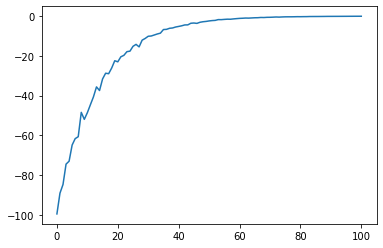

In [18]:
plt.plot(rewards)

In [19]:
env, spec = query_environment('MountainCarContinuous-v0')
env = Monitor(env, './video', force=True)
env.render()

try:
    obs = env.reset()
    cum_rewards = 0
    action = nn_agent.agent_start(obs)

    for t in range(1000):
        obs, reward, done, info = env.step(action)
        cum_rewards += reward

        if done:
            nn_agent.agent_end(reward, obs)
            print('Reward: %0.1f' % cum_rewards, '/ Episode length', t+1)
            break
        else: action = nn_agent.agent_step(reward, obs)
finally: env.close()

Action Space: Box([-1.], [1.], (1,), float32)
Observation Space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Max Episode Steps: 999
Nondeterministic: False
Reward Range: (-inf, inf)
Reward Threshold: 90.0
Reward: -0.1 / Episode length 999


In [ ]:
nn_agent = PPO(
    policy='MlpPolicy',
    env=env,
    seed=0,
    batch_size=256,
    ent_coef=0.00429,
    learning_rate=7.77e-05,
    n_epochs=10,
    n_steps=8,
    gae_lambda=0.9,
    gamma=0.9999,
    clip_range=0.1,
    max_grad_norm =5,
    vf_coef=0.19,
    use_sde=True,
    policy_kwargs=dict(log_std_init=-3.29, ortho_init=False),
    verbose=1,
    )
nn_agent.learn(10000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 3398 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 8    |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 349          |
|    iterations           | 2            |
|    time_elapsed         | 0            |
|    total_timesteps      | 16           |
| train/                  |              |
|    approx_kl            | 0.0010981262 |
|    clip_fraction        | 0.1          |
|    clip_range           | 0.1          |
|    entropy_loss         | 1.3          |
|    explained_variance   | -0.344       |
|    learning_rate        | 7.77e-05     |
|    loss                 | 0.00504      |
|    n_updates            | 10           |
|    policy_gradient_loss | 0.000655     |
|    std

/Users/luchungi/opt/anaconda3/envs/drl-torch-mps/lib/python3.9/site-packages/stable_baselines3/ppo/ppo.py:137: UserWarning: You have specified a mini-batch size of 256, but because the `RolloutBuffer` is of size `n_steps * n_envs = 8`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 8
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=8 and n_envs=1)
  warnings.warn(


------------------------------------------
| time/                   |              |
|    fps                  | 369          |
|    iterations           | 10           |
|    time_elapsed         | 0            |
|    total_timesteps      | 80           |
| train/                  |              |
|    approx_kl            | 7.709116e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.1          |
|    entropy_loss         | 1.3          |
|    explained_variance   | 0.274        |
|    learning_rate        | 7.77e-05     |
|    loss                 | 0.0034       |
|    n_updates            | 90           |
|    policy_gradient_loss | -0.00087     |
|    std                  | 0.0372       |
|    value_loss           | 3.77e-05     |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 375          |
|    iterations           | 11           |
|    time_e

# Diagnosis

In [ ]:
# Q-VALUE BETWEEN MOVING FORWARD OR BACKWARD WHEN CLOSE TO GOAL IS TOO CLOSE AND WRONG DIRECTION IS ACTUALLY SLIGHTLY HIGHER

X = np.linspace(-1.2, 0.6, 19)
Y = np.linspace(-0.07, 0.07, 8)

Q = []
TQ = []
QDIFF = []
TQDIFF = []

for v in Y:
    for x in X:
        obs = torch.tensor([x, v], dtype=torch.float32)
        act = torch.tensor([1], dtype=torch.float32)
        Q.append(nn_agent.critic([obs, act])[0])
        TQ.append(nn_agent.target_critic([obs, act])[0])

        act = torch.tensor([-1], dtype=torch.float32)
        QDIFF.append(Q[-1] - nn_agent.critic([obs, act])[0])
        TQDIFF.append(TQ[-1] - nn_agent.target_critic([obs, act])[0])

AttributeError: 'PPO' object has no attribute 'critic'

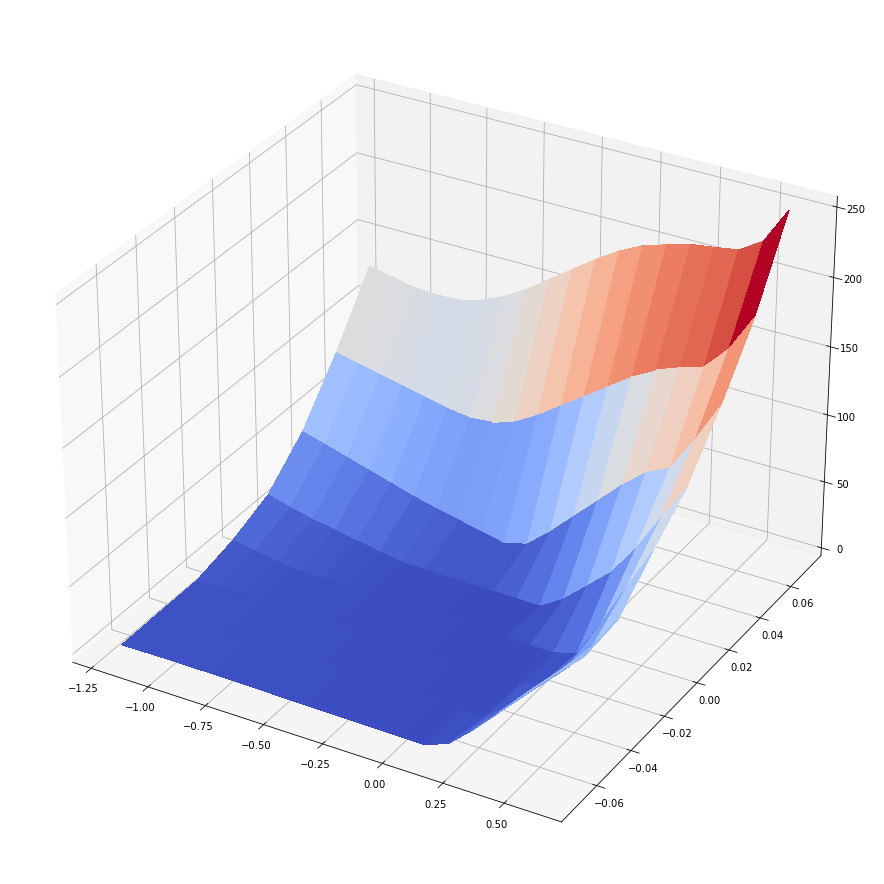

In [ ]:
X, Y = np.meshgrid(X, Y)
Q = np.array([value.detach().numpy() for value in Q]).reshape(X.shape)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(16, 16))
surf = ax.plot_surface(X, Y, Q, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

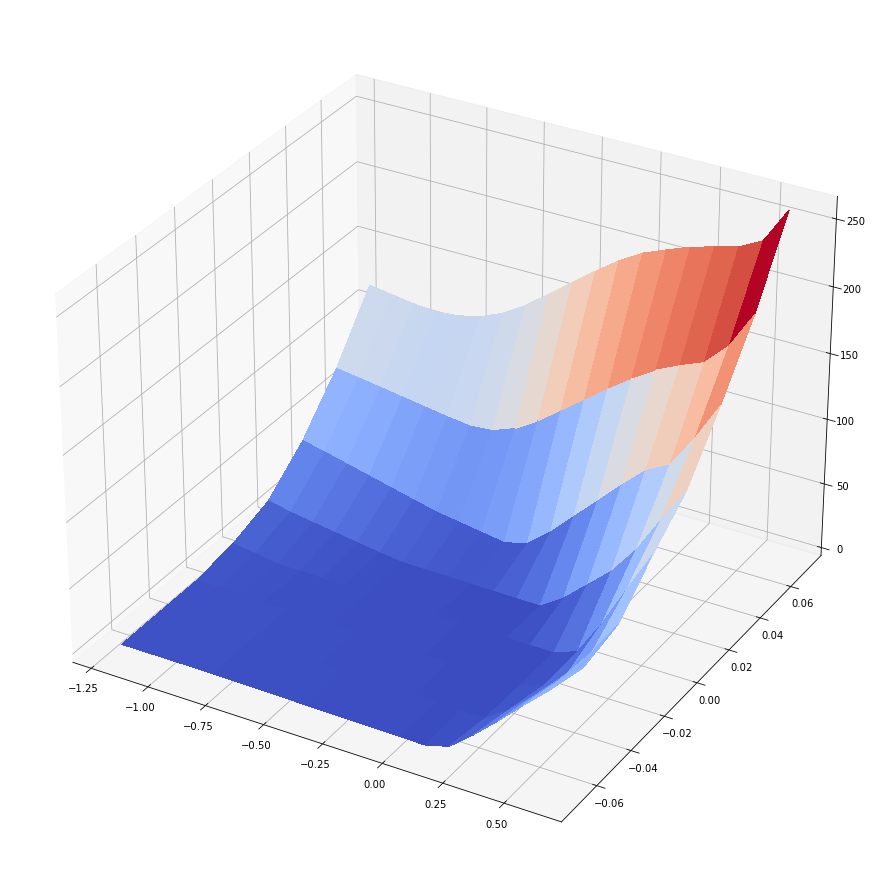

In [ ]:
TQ = np.array([value.detach().numpy() for value in TQ]).reshape(X.shape)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(16, 16))
surf = ax.plot_surface(X, Y, TQ, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

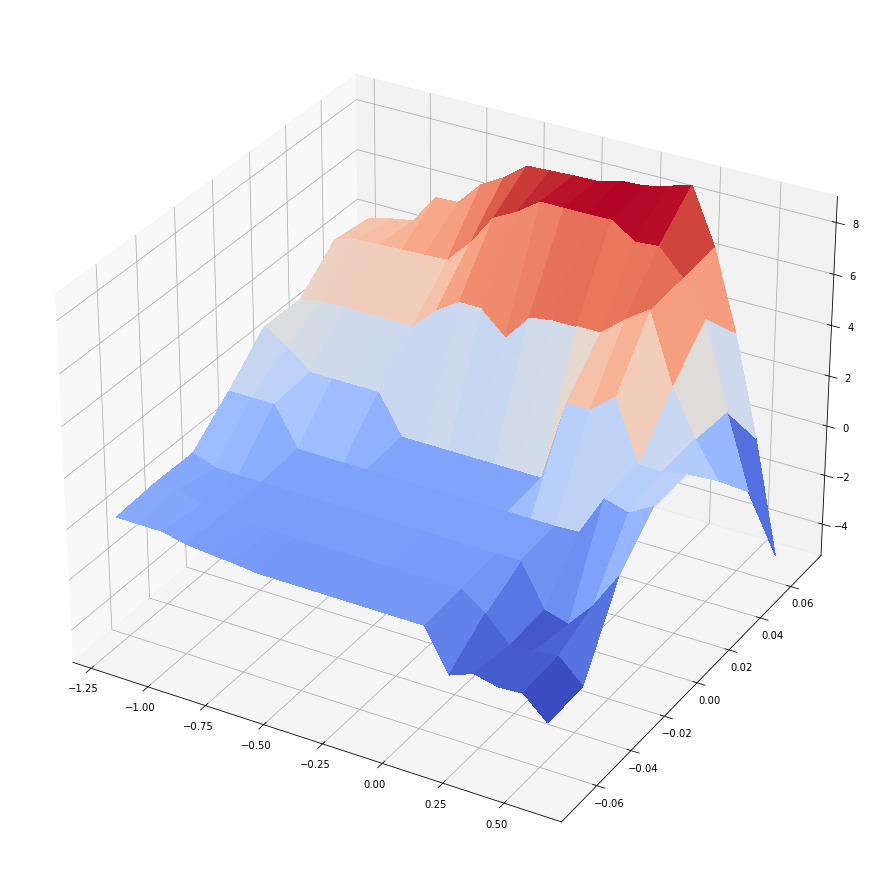

In [ ]:
QDIFF = np.array([value.detach().numpy() for value in QDIFF]).reshape(X.shape)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(16, 16))
surf = ax.plot_surface(X, Y, QDIFF, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

In [ ]:
obs = torch.tensor([-0.5, 0.05], dtype=torch.float32)
act = torch.tensor([1], dtype=torch.float32)
print('Action = 1')
print('Q:', nn_agent.critic([obs, act]))
print('A:', nn_agent.actor(obs))
print('TQ:', nn_agent.target_critic([obs, act]))
print('TA:', nn_agent.target_actor(obs))

act = torch.tensor([-1], dtype=torch.float32)
print('\nAction = -1')
print('Q:', nn_agent.critic([obs, act]))
print('A:', nn_agent.actor(obs))
print('TQ:', nn_agent.target_critic([obs, act]))
print('TA:', nn_agent.target_actor(obs))

Action = 1
Q: tensor([-1.3829], grad_fn=<AddBackward0>)
A: tensor([0.9986], grad_fn=<TanhBackward0>)
TQ: tensor([-1.3253], grad_fn=<AddBackward0>)
TA: tensor([0.9986], grad_fn=<TanhBackward0>)

Action = -1
Q: tensor([-1.3829], grad_fn=<AddBackward0>)
A: tensor([0.9986], grad_fn=<TanhBackward0>)
TQ: tensor([-1.3253], grad_fn=<AddBackward0>)
TA: tensor([0.9986], grad_fn=<TanhBackward0>)
